<a href="https://colab.research.google.com/github/lukaszrbk/Coursera_Capstone/blob/master/Nov16PracaInz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Analiza sentymentu z wykorzystaniem uczenia maszynowego w predykcji wahań kursu akcji giełdowych**

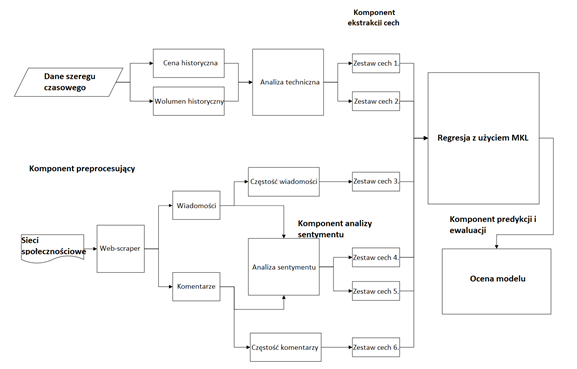

Model zaproponowany w ramach artykułu:
***Combining Technical Analysis with Sentiment Analysis for Stock Price Prediction***, IEEE Ninth International Conference on Dependable, Autonomic and Secure Computing 2011. przez S. Deng, T. Mitsubuchi, K. Shioda, T. Shimada, A. Sakurai

---
### **Komponent ekstrakcji parametrów giełdowych**

wykorzystuje API serwisu ALPHA VANTAGE, zawierające aktualne wartości technicznych wskaźników giełdowych dla wybranych giełd i spółek

In [ ]:
%matplotlib inline

In [ ]:
import requests
import json
import pandas as pd
from datetime import datetime as dtm

In [ ]:
# do rozważenia biblioteka graficzna dla wizualizacji wyników działania skryptu
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# folder operacyjny dla skryptu znajduje się w chmurze
from google.colab import drive
drive.mount("/content/drive")

operationsFolder = r"/content/drive/MyDrive/inz-praktyka" 
configPath = operationsFolder + r"/config.txt"

with open(configPath) as conf:
  config = json.load(conf)

**MACD** - generuje swoje sygnały na podstawie dwóch średnich wykładniczych (średnie EMA). Standardowe ustawienia tego wskaźnika sugerują MACD jako wynik odejmowania od 26-cio okresowej EMA, średniej 12-sto okresowej EMA. Nakładając wskaźnik na okno wykresu otrzymamy histogram poruszający się wokół poziomu zero, z przecinającymi się nawzajem liniami MACD oraz Signal. Linia Signal to 9-cio okresowa średnia krocząca wskaźnika MACD. Tak jak większość wskaźników, MACD powstała z myślą wykorzystania na wykresie dziennym, stąd też generuje najlepsze sygnały w średnim oraz długim terminie. Można oczywiście go wykorzystać na niższym interwale, jednakże warto pamiętać, że z racji konstrukcji może generować opóźnione sygnały.

**ROC** (Rate of Change)- Przy jego pomocy obliczamy zmianę ceny między poszczególnymi okresami, a wynik przedstawiany jest w procentach. W praktyce, ROC bierze pod uwagę aktualną cenę, a następnie porównuje ją z cenami z określonego okresu czasu.

**SMA**- liczy się ją przez dodanie do siebie (przeważnie) cen zamknięcia z ustalonej liczby okresów historycznych, a uzyskaną sumę dzieli przez ich liczbę.

In [ ]:
stockDataPath = operationsFolder + r"/stockDataGieldowe.csv"

apiKey = config['stockApiKey']

# api dla technicznej analizy giełdowej
apiTimeSeriesUrl = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=AAPL&apikey={apiKey}&datatype=csv&outputsize=full' # dane o wolumenie i cenie na zamknięcie
apiRocUrl = f'https://www.alphavantage.co/query?function=ROC&symbol=AAPL&apikey={apiKey}&datatype=csv&series_type=close&time_period=1&interval=daily' # ROC
apiMacdUrl = f'https://www.alphavantage.co/query?function=MACD&symbol=AAPL&apikey={apiKey}&datatype=csv&series_type=close&interval=daily' # MACD
apiSmaUrl = f'https://www.alphavantage.co/query?function=SMA&symbol=AAPL&apikey={apiKey}&datatype=csv&series_type=close&interval=daily&time_period=20' # SMA

apiUrls = [apiTimeSeriesUrl,apiRocUrl,apiMacdUrl,apiSmaUrl]

mergedStockData = pd.DataFrame()

for url in apiUrls:
  responce = requests.get(url)
  stockData = responce.text
  with open(stockDataPath, "w") as csvFile:
    csvFile.write(stockData)
  stockDataDf = pd.read_csv(stockDataPath)
  print(stockDataDf.head(5))
  print("\n"*3)
  mergedStockData = pd.concat([mergedStockData, stockDataDf[stockDataDf.columns.difference(['time'])]], axis=1) # połączenie danych giełdowych w jedną tabelę

print(mergedStockData)

    timestamp    open     high       low   close    volume
0  2021-11-15  150.37  151.880  149.4300  150.00  59222803
1  2021-11-12  148.43  150.400  147.4800  149.99  63245197
2  2021-11-11  148.96  149.430  147.6810  147.87  40999950
3  2021-11-10  150.02  150.130  147.8500  147.92  65187092
4  2021-11-09  150.20  151.428  150.0601  150.81  56573449




         time     ROC
0  2021-11-15  0.0067
1  2021-11-12  1.4337
2  2021-11-11 -0.0338
3  2021-11-10 -1.9163
4  2021-11-09  0.2459




         time    MACD  MACD_Hist  MACD_Signal
0  2021-11-15  0.9506    -0.1727       1.1233
1  2021-11-12  0.9744    -0.1920       1.1664
2  2021-11-11  0.9918    -0.2227       1.2144
3  2021-11-10  1.2153    -0.0548       1.2701
4  2021-11-09  1.4779     0.1941       1.2838




         time       SMA
0  2021-11-15  149.6141
1  2021-11-12  149.4310
2  2021-11-11  149.1630
3  2021-11-10  148.9471
4  2021-11-09  148.5863




       close     high       low  ...  MACD_Hist MACD_Signal       SMA
0     15

Wstępna weryfikacja potwierdza, że dane zostały pobrane poprawnie.

Wyliczamy ostatni z potrzebnych wskaźników technicznych- **BIAS**. Jest to procentowy wskaźnik, ilustrujący różnicę między kursem zamknięcia a prostą średnią kroczącą.

In [ ]:
mergedStockData['BIAS']=((mergedStockData.close-mergedStockData.SMA)/mergedStockData.SMA)*100

In [ ]:
mergedStockData.dtypes

close          float64
high           float64
low            float64
open           float64
timestamp       object
volume           int64
ROC            float64
MACD           float64
MACD_Hist      float64
MACD_Signal    float64
SMA            float64
BIAS           float64
dtype: object

Po sprawdzeniu typów danych okazuje się, że data wymaga konwersji

In [ ]:
mergedStockData['timestamp'] = pd.to_datetime(mergedStockData['timestamp'], format="%Y-%m-%d")

In [ ]:
mergedStockData.head(5)

,close,high,low,open,timestamp,volume,ROC,MACD,MACD_Hist,MACD_Signal,SMA,BIAS
0,150.00,151.880,149.4300,150.37,2021-11-15,59222803,0.0067,0.9506,-0.1727,1.1233,149.6141,0.257930
1,149.99,150.400,147.4800,148.43,2021-11-12,63245197,1.4337,0.9744,-0.1920,1.1664,149.4310,0.374086
2,147.87,149.430,147.6810,148.96,2021-11-11,40999950,-0.0338,0.9918,-0.2227,1.2144,149.1630,-0.866837
3,147.92,150.130,147.8500,150.02,2021-11-10,65187092,-1.9163,1.2153,-0.0548,1.2701,148.9471,-0.689574
4,150.81,151.428,150.0601,150.20,2021-11-09,56573449,0.2459,1.4779,0.1941,1.2838,148.5863,1.496571


Połączone kolumny wyglądają prawidłowo

In [ ]:
mergedStockData.tail(50)

,close,high,low,open,timestamp,volume,ROC,MACD,MACD_Hist,MACD_Signal,SMA,BIAS
5497,92.75,99.37,90.50,95.94,2000-01-11,3942400,-5.1151,0.0016,-0.0100,0.0116,0.7650,12024.183007
5498,97.75,102.25,94.75,102.00,2000-01-10,4509500,-1.7588,0.0069,-0.0072,0.0141,0.7674,12637.816002
5499,99.50,101.00,95.50,96.50,2000-01-07,4113700,4.7368,0.0097,-0.0062,0.0159,0.7694,12832.154926
5500,95.00,107.00,95.00,106.12,2000-01-06,6856900,-8.6538,0.0118,-0.0056,0.0174,0.7716,12212.078797
5501,104.00,110.56,103.00,103.75,2000-01-05,6949300,1.4634,0.0178,-0.0010,0.0188,0.7773,13279.647498
5502,102.50,110.62,101.19,108.25,2000-01-04,4574800,-8.4331,0.0181,-0.0009,0.0190,0.7826,12997.367749
5503,111.94,112.50,101.69,104.87,2000-01-03,4783900,8.8805,0.0195,0.0003,0.0193,0.7878,14109.190150
5504,102.81,102.87,99.50,100.94,1999-12-31,1462600,2.4923,0.0137,-0.0056,0.0192,0.7890,12930.418251
5505,100.31,104.12,99.62,102.19,1999-12-30,1849500,-0.3774,0.0131,-0.0075,0.0206,0.7918,12568.603183
5506,100.69,102.19,95.50,96.81,1999-12-29,2540200,2.5461,0.0141,-0.0084,0.0225,0.7928,12600.554995


Uzyskane dane różnią się co do zakresu dat- część pomiarów paramterów kończy się nieco wcześniej. Należy uwzględnić to w analizach, chociaż najprawdpodobniej nie będą sięgać aż tak długiego okresu.

W historii spółki Apple wystąpiło pięć splitów- jeden z nich przed rokiem 2000, a więc nie uwzględniony w pomiarach.

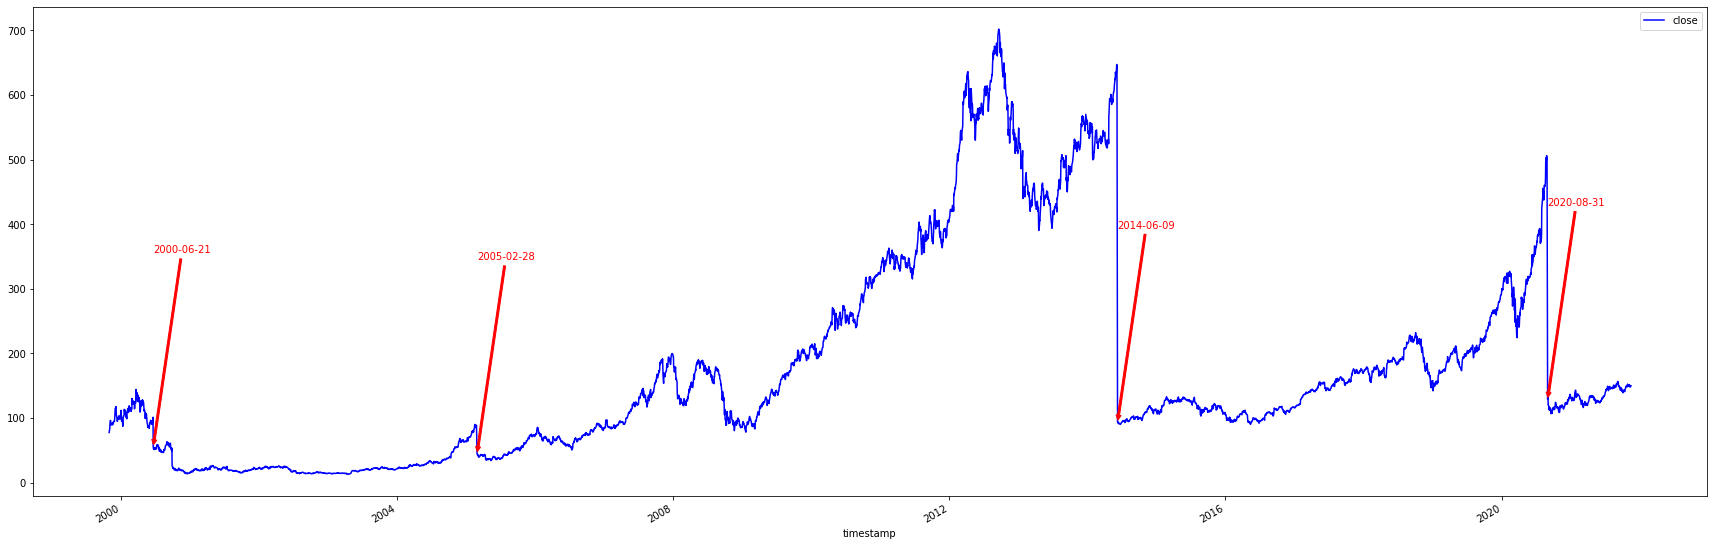

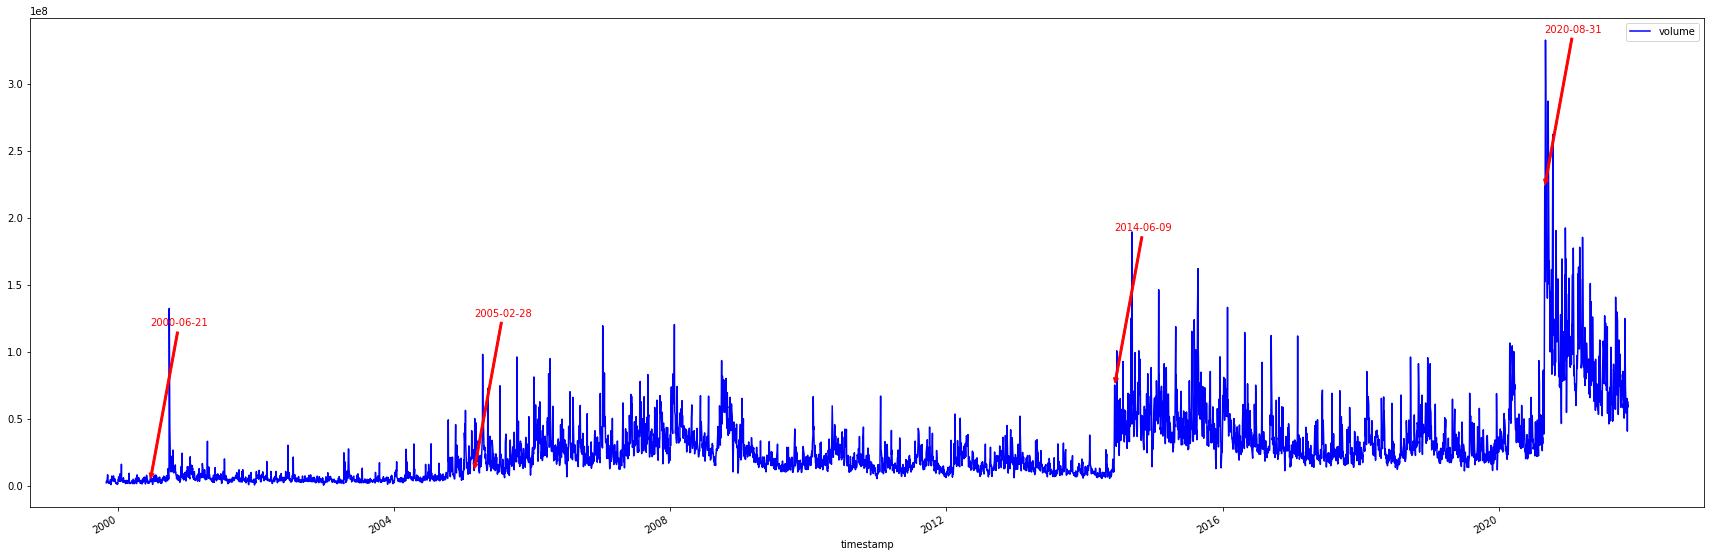

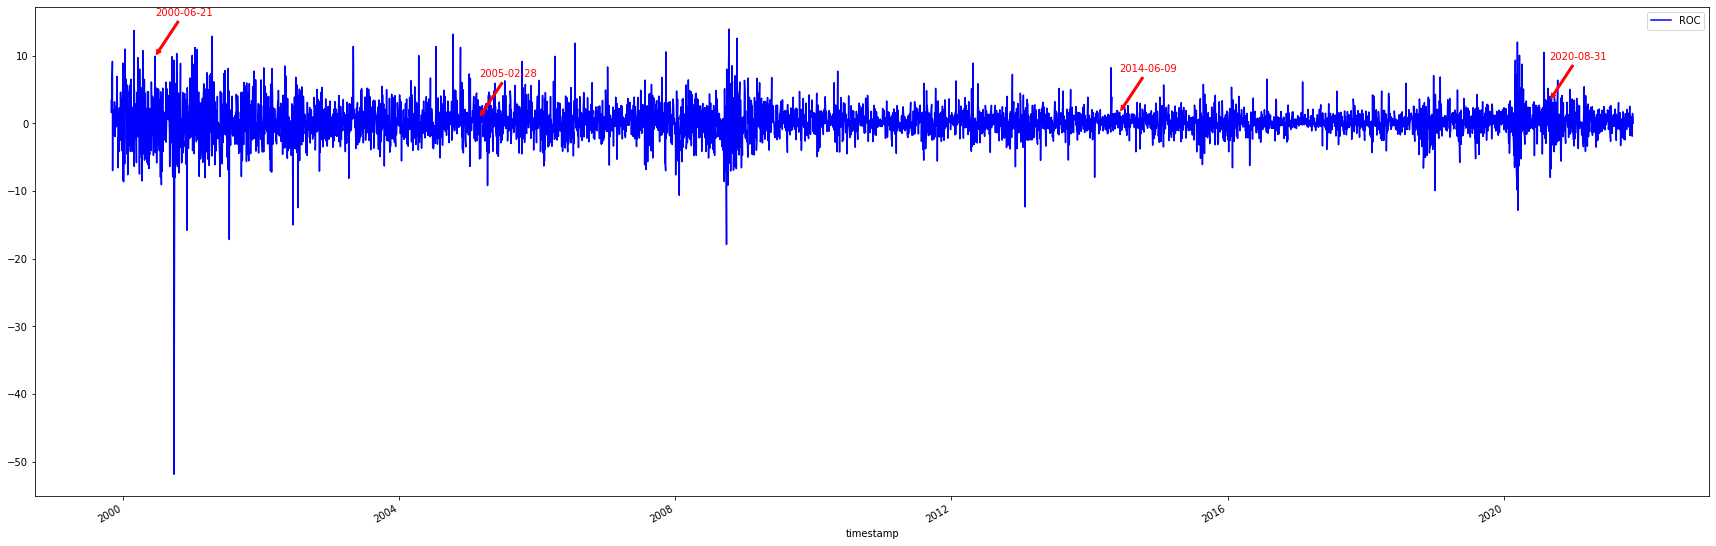

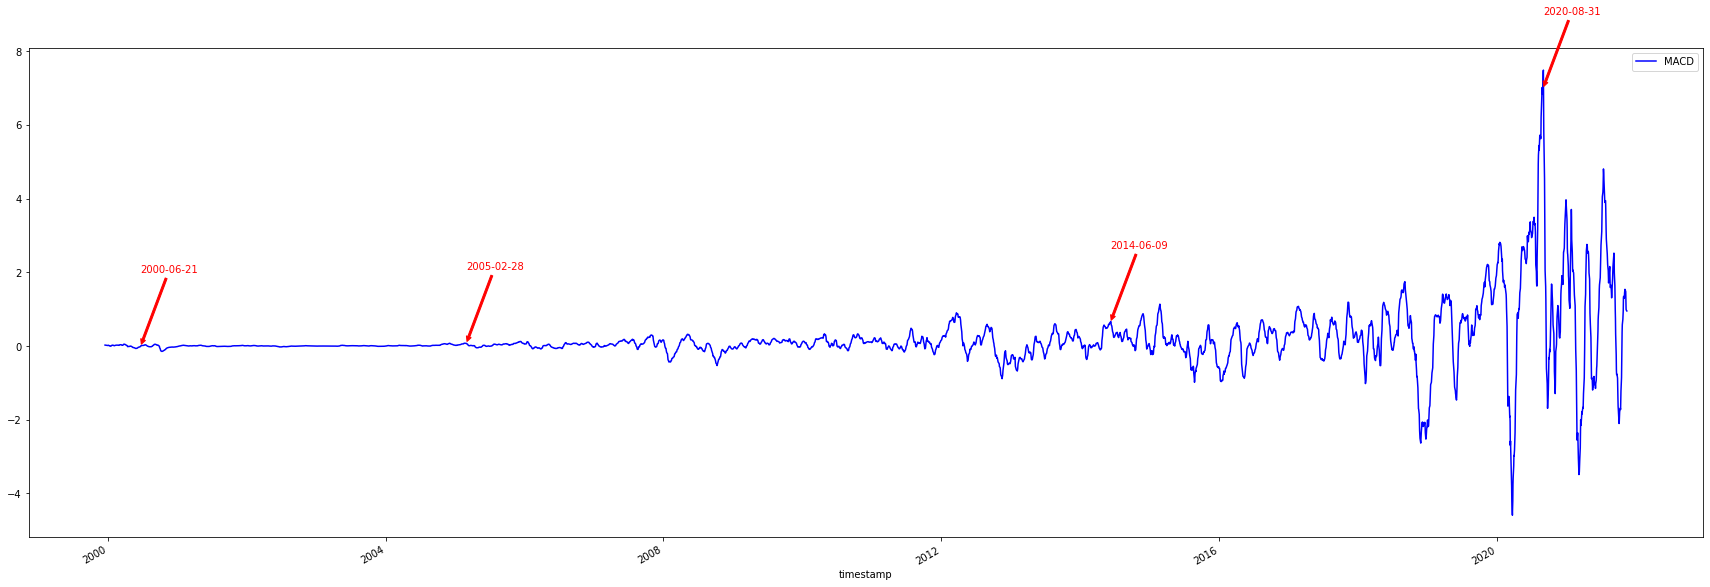

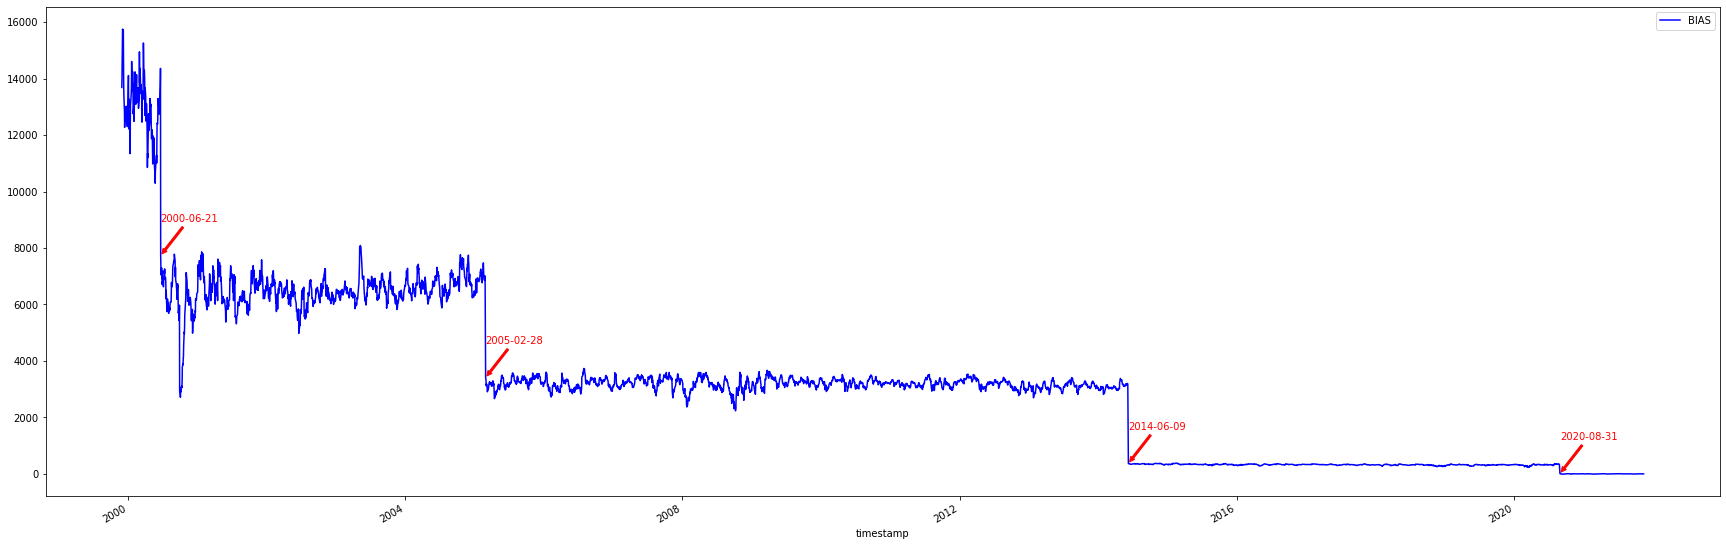

In [ ]:
splitHistory = ['2000-06-21','2005-02-28','2014-06-09','2020-08-31'] #http://www.stocksplithistory.com/apple
parameters = ['close','volume','ROC','MACD','BIAS']
offset = [300,115000000,6,2,1200]

for parameter in parameters:
  figure1 = mergedStockData.plot(kind='line',x='timestamp',y=parameter,color='blue')
  figure1.figure.set_figwidth(30)
  figure1.figure.set_figheight(10)
  for splitTime in splitHistory:
    x = dtm.strptime(splitTime, '%Y-%m-%d')
    y = list(mergedStockData.loc[mergedStockData['timestamp'] == splitTime,parameter])[0]
    figure1.annotate(str(splitTime), xy=(x, y), xytext=(x, y+offset[parameters.index(parameter)]),color='red', arrowprops=dict(arrowstyle="simple",color='red'))

***PODEJŚCIE ALTERNATYWNE DO WYKRESU (WYKRES INTERAKTYWNY), W OPARCIU O BOKEH***

In [ ]:
!pip install bokeh

In [ ]:
import datetime

In [ ]:
'''
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, CDSView, BooleanFilter, HoverTool, FactorRange
from bokeh.transform import factor_cmap, cumsum
from bokeh.layouts import row, column, gridplot
from bokeh.models.widgets import Tabs, Panel
'''
from bokeh.plotting import figure, show
from bokeh.models import HoverTool
from bokeh.models import Arrow, NormalHead
from bokeh.io import output_notebook
from bokeh.resources import INLINE
output_notebook(INLINE)



In [ ]:
figure1 = figure(title="Dzienny kurs zamknięcia (AAPL)",x_axis_type="datetime",x_axis_label='Data')
figure1.line(x='timestamp', y='close', source=mergedStockData, legend_label="Kurs zamknięcia")
figure1.add_tools(HoverTool(tooltips=[("Data","$x{%F}"),("Kurs","$y{"+f"0.00"+" a}")],formatters={'$x':'datetime',},))
figure1.legend.location = 'bottom_right'

def time_to_microseconds(t):
  dmin = datetime.datetime.min
  dummy_tdelta = (datetime.datetime.combine(dmin, t) - dmin)
  #dummy_tdelta = t - dmin
  return dummy_tdelta.total_seconds()*1000

for splitTime in splitHistory:
  x = dtm.strptime(splitTime, '%Y-%m-%d')
  y = list(mergedStockData.loc[mergedStockData['timestamp'] == splitTime,'close'])[0]
  x = x.timestamp()*1000000
  figure1.add_layout(Arrow(end=NormalHead(line_color="firebrick", line_width=40),x_start=x, y_start=y, x_end=x, y_end=600))


show(figure1)

---
### **Komponent wyszukiwania danych w serwisie Youtube**

*WYSZUKIWANIE WIDEO*

- data publikacji filmu w odpowiednim zakresie czasowym
- wyniki wyszukiwania o największym znaczeniu
- wyszukiwanie pod katem slow kluczowych, wszystkich znanych produktow firmy Apple

In [ ]:
import os
import googleapiclient.discovery
from dataclasses import dataclass
from typing import Any, List, TypeVar, Type, cast, Callable
from datetime import datetime
import dateutil.parser

Funkcja inicjalizująca klienta API YouTube. Przygotowana w oparciu o oficjalną dokumentację interfejsu:

In [ ]:
def ytClientInit() -> googleapiclient.discovery:
  # Wyłączenie weryfikacji HTTPS przez OAuthlib przy testowym uruchomieniu
  # *NIE WŁĄCZAĆ* tej opcji w środowisku produkcyjnym
  os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1" if environment == 'TEST' else "0"

  apiServiceName = "youtube" # wersja 3. Youtube Data API
  apiVersion = "v3"
  developerKey = config['developerKey'] # unikalny klucz, quota 10000 jednostek/dzień

  return googleapiclient.discovery.build(apiServiceName, apiVersion, developerKey=developerKey)

Funkcja pobierająca wyniki do tabeli Pandas, na podstawie zawartości odpowiedzi serwera:

In [ ]:
def fetchVideos(response: str, commentsdt: pd.DataFrame) -> None:
  newPage = Response.fromDict(response)
  for item in newPage.items:
      if item.snippet.publishedAt:
          commentsdt.loc[len(commentsdt)] = [item.snippet.publishedAt, item.snippet.channelId,
                                              item.snippet.channelTitle, item.id.videoId, item.snippet.title]

Zapytanie do API o zwrócenie wyników wyszukiwania danego hasła (produktu marki Apple) :

In [ ]:
language = "en" # język wyników wyszukiwania
sortingOrder ="relevance" # dostępne opcje: date/rating/relevance/title/videoCount/viewCount

def searchVideos(phrase: str, publishStartDate: datetime, publishEndDate: datetime, youtubeClient: googleapiclient.discovery) -> pd.DataFrame:

  phrase=phrase.replace(" ", "+")

  videosDt = pd.DataFrame(columns=['publishedAt', 'channelId', 'channelTitle', 'videoId', 'videoTitle']) # nagłówki kolumn w tabeli wynikowej Pandas

  def searchYoutubeVid(phrase: str, publishStartDate: datetime, publishEndDate: datetime, response: str = "") -> str:
    nonlocal youtubeClient
    args = {
      'part' : "snippet",
      'maxResults' : 50,  # może przyjmować wartości między 1-50 wyników na stronę
      'order' : sortingOrder,
      'q' : phrase,
      'type' : 'video',
      'relevanceLanguage' : language,
      'publishedAfter' : publishStartDate.strftime("%Y-%m-%dT%H:%M:%SZ"),
      'publishedBefore' : publishEndDate.strftime("%Y-%m-%dT%H:%M:%SZ")
      }
    if response:
      args['pageToken'] = Response.fromDict(response).nextPageToken # jeżeli dostępny jest token następnej strony, to kolejne wywołanie API powinno się do niego odnieść
   
    request = youtubeClient.search().list(**args) # 100 jednostek pobierane z quoty przy każdym wywołaniu
    return request.execute()

  i = 0
  response = searchYoutubeVid(phrase, publishStartDate, publishEndDate)
  fetchVideos(response, videosDt)

  while Response.fromDict(response).nextPageToken and i < testIterationsVid: # limit iteracji dodany w środowisku testowym- ograniczenie wykorzystania limitu wywołań API
      response = searchYoutubeVid(phrase, publishStartDate, publishEndDate, response)
      fetchVideos(response, videosDt)
      if environment == 'TEST': i += 1

  return videosDt

Asercje niezbędne do upewnienia się, że odpowiedź serwera zawiera oczekiwane atrybuty:

In [ ]:
T = TypeVar("T") # typ generyczny, wykorzystywany przy typowaniu


def from_str(x: Any) -> str:
  assert isinstance(x, str)
  return x


def from_int(x: Any) -> int:
  assert isinstance(x, int) and not isinstance(x, bool)
  return x


def to_class(c: Type[T], x: Any) -> dict:
  assert isinstance(x, c)
  return cast(Any, x).to_dict()


def from_datetime(x: Any) -> datetime:
  return dateutil.parser.parse(x)


def from_list(f: Callable[[Any], T], x: Any) -> List[T]:
  assert isinstance(x, list)
  return [f(y) for y in x]

def from_bool(x: Any) -> bool:
  assert isinstance(x, bool)
  return x

Odpowiedź w formacie json jest przekształcana do postaci klasy i jej atrybutów:

In [ ]:
@dataclass
class ID:
  kind: str
  videoId: str

  @staticmethod
  def fromDict(obj: Any) -> 'ID':
    assert isinstance(obj, dict)
    kind = from_str(obj.get("kind"))
    videoId = from_str(obj.get("videoId"))
    return ID(kind, videoId)


@dataclass
class Snippet:
  publishedAt: datetime
  channelId: str
  title: str
  description: str
  channelTitle: str
  liveBroadcastContent: str
  publishTime: datetime

  @staticmethod
  def fromDict(obj: Any) -> 'Snippet':
    assert isinstance(obj, dict)
    publishedAt = from_datetime(obj.get("publishedAt"))
    channelId = from_str(obj.get("channelId"))
    title = from_str(obj.get("title"))
    description = from_str(obj.get("description"))
    channelTitle = from_str(obj.get("channelTitle"))
    liveBroadcastContent = from_str(obj.get("liveBroadcastContent"))
    publishTime = from_datetime(obj.get("publishTime"))
    return Snippet(publishedAt, channelId, title, description, channelTitle, liveBroadcastContent, publishTime)


@dataclass
class Item:
  kind: str
  etag: str
  id: ID
  snippet: Snippet

  @staticmethod
  def fromDict(obj: Any) -> 'Item':
    assert isinstance(obj, dict)
    kind = from_str(obj.get("kind"))
    etag = from_str(obj.get("etag"))
    id = ID.fromDict(obj.get("id"))
    snippet = Snippet.fromDict(obj.get("snippet"))
    return Item(kind, etag, id, snippet)


@dataclass
class PageInfo:
  totalResults: int
  resultsPerPage: int

  @staticmethod
  def fromDict(obj: Any) -> 'PageInfo':
    assert isinstance(obj, dict)
    totalResults = from_int(obj.get("totalResults"))
    resultsPerPage = from_int(obj.get("resultsPerPage"))
    return PageInfo(totalResults, resultsPerPage)


@dataclass
class Response:
  kind: str
  etag: str
  nextPageToken: str
  regionCode: str
  pageInfo: PageInfo
  items: List[Item]

  @staticmethod
  def fromDict(obj: Any) -> 'Response': # przemyslec, czy nie stworzyc nowej instancji NewType (typing)
    assert isinstance(obj, dict)
    kind = from_str(obj.get("kind"))
    etag = from_str(obj.get("etag"))
    regionCode = from_str(obj.get("regionCode"))
    pageInfo = PageInfo.fromDict(obj.get("pageInfo"))
    items = from_list(Item.fromDict, obj.get("items"))

    try:
      nextPageToken = from_str(obj.get("prevPageToken"))
    except:
      nextPageToken = ""

    return Response(kind, etag, nextPageToken, regionCode, pageInfo, items)

CECHY WYSZUKIWANYCH HASEŁ- PRODUKTÓW FIRMY APPLE:

- produkty musza kojarzyć się tylko (głównie) z firmą Apple
- produkty musza wywolywać emocje/kontrowersje- większość peryferiów nie jest brana pod uwagę
- hasła muszą jednoznacznie identyfikować dany produkt lub ich serie
- jezeli nazwy sa dwuznaczne, to wyszukiwana fraza musi zawierać 'Apple' jako pierwszy człon nazwy - np. zamiast Safari -> Apple Safari
- analizujemy produkty wprowadzane przez Apple w niedawnym czasie, lub wciąż utrzymywane na rynku

Testowanie wyszukiwania materiałów wideo:

In [ ]:
environment = "TEST"

ytClient = ytClientInit()

testIterationsVid = 1

searchPhrases = ["AirTag", "Apple TV", "Apple Watch", "HomePod mini", "iMac", "iPad", "iPhone", "iPod", "MacBook", "bridgeOS", "HomePod Software", "iOS", "IPadOS", "macOS", "watchOS", "Apple Arcade", "Apple Business Essentials", "Apple Card", "Apple Fitness+", "Apple One", "Apple Music", "Apple News+", "Apple Store", "Apple TV+", "FaceTime", "iTunes Store", "Final Cut Pro X", "iCloud", "iLife", "iMessage", "iMovie", "iTunes", "iWork", "Apple Logic Pro X", "Mac App Store", "Apple Photos", "Apple Safari", "AirPods", "Apple MagSafe", "Apple Pencil", "Apple Remote", "Apple Thunderbolt Cable", "Apple Watch Magnetic Charging Dock", "Apple World Travel Adapter Kit", "EarPods", "Mac Pro Feet Kit", "Mac Pro Security Lock Adapter", "Mac Pro Wheels Kit", "Apple Magic Keyboard", "Apple Magic Mouse", "Apple Magic Trackpad", "MagSafe Battery Pack", "MagSafe Charger", "Apple Polishing Cloth", "Apple Pro Stand", "Siri Remote"]
#searchPhrases = ["AirPods", "AirPods Max", "AirPods Pro", "Apple HDMI to DVI Adapter", "Apple MagSafe Power Adapter", "Apple MagSafe 2 Power Adapter", "Apple Pencil", "Apple Remote", "Apple Thunderbolt Cable", "Apple Thunderbolt to FireWire Adapter", "Apple USB Ethernet Adapter", "Apple USB Power Adapter", "Apple Watch Magnetic Charging Cable", "Apple Watch Magnetic Charging Dock", "Apple Watch Magnetic Fast Charger to USB-C Cable", "Apple World Travel Adapter Kit", "Apple 30-pin to USB Cable", "Apple 30-pin to VGA Adapter", "EarPods", "iPhone Leather Case with MagSafe", "iPhone Leather Wallet with MagSafe", "iPhone 12 Leather Sleeve with MagSafe", "iPhone TTY Adapter", "Lightning Digital AV Adapter", "Lightning to Micro USB Adapter", "Lightning to SD Card Camera Reader", "Lightning to USB 3 Camera Adapter", "Lightning to USB Cable", "Lightning to USB Camera Adapter", "Lightning to VGA Adapter", "Lightning to 3.5mm Audio Cable", "Lightning to 3.5 mm Headphone Jack Adapter", "Lightning to 30-pin Adapter", "Mac Pro Feet Kit", "Mac Pro Security Lock Adapter", "Mac Pro Wheels Kit", "Magic Keyboard", "Magic Keyboard for iPad", "Magic Mouse 2", "Magic Trackpad", "MagSafe Battery Pack", "MagSafe Charger", "MagSafe Duo Charger", "MagSafe to MagSafe 2 Converter", "Polishing Cloth", "Power Adapter Extension Cable", "Pro Display XDR", "Pro Stand", "Remote Loop", "Siri Remote", "Smart Battery Case", "Smart Cover", "Smart Folio", "Smart Keyboard", "Smart Keyboard Folio", "SSD Kit for Mac Pro", "SuperDrive", "Thunderbolt 3 (USB-C) Cable", "Thunderbolt 3 to Thunderbolt 2 Adapter", "Thunderbolt 3 Pro Cable", "Thunderbolt to Gigabit Ethernet Adapter", "USB-C Charge Cable", "USB-C Digital AV Multiport Adapter", "USB-C Power Adapter", "USB-C to 3.5 mm Headphone Jack Adapter", "USB-C to Lightning Cable", "USB-C to MagSafe 3 Cable", "USB-C to SD Card Reader", "USB-C to USB Adapter", "USB-C VGA Mutiport Adapter", "VESA Mount Adapter", "VESA Mount Adapter Kit for iMac Pro", "AirTag", "Apple TV HD", "Apple TV 4K", "Apple Watch", "Apple Watch SE", "HomePod mini", "iMac", "iPad", "iPad Air", "iPad mini", "iPad Pro", "iPhone", "iPhone SE", "iPod touch", "Mac mini", "Mac Pro", "MacBook Air", "MacBook Pro", "bridgeOS", "HomePod Software", "iOS", "IPadOS", "macOS", "tvOS", "watchOS", "App Store", "Apple Arcade", "Apple Business Essentials", "Apple Card", "Apple Developer (app)", "Apple Fitness+", "Apple One", "Apple Music", "Apple News+", "Apple Store", "Apple TV+", "FaceTime", "iTunes Store", "Compressor", "Feedback Assistant", "Final Cut Pro X", "GarageBand", "iCloud", "iLife", "iMessage", "iMovie", "iTunes", "iWork", "Logic Pro X", "Mac App Store", "Motion", "Photos", "Safari"]
searchPhrases = ['macbook pro']

begin = datetime(2021, 11, 10) # czas UTC
end = datetime(2021, 11, 12) # czas UTC
videoDts = []

try:
  for phrase in searchPhrases:
    videoInfos = searchVideos(phrase, begin, end, ytClient) 
    videoDts.append(videoInfos)
except:
  print('Blad podczas wyszukiwania materialow wideo.')
finally: # w przypadku przekroczenia quoty, zapisujemy zebrane dotychczas wyniki
  mergedVideoInfos = pd.concat(videoDts, sort=False)
  mergedVideoInfos.reset_index(inplace=True, drop=True)

  mergedVideoInfos['publishedAt']=pd.to_datetime(mergedVideoInfos['publishedAt'], format="%Y-%m-%dT%H:%M:%SZ") # konwersja tekstu do dat

  mergedVideoInfos.sort_values(inplace=True, by='publishedAt') # opcjonalne sortowanie względem dat dodania filmu

  uniqueVideoInfos = mergedVideoInfos.drop_duplicates() # api czesto zwraca zduplikowane rekordy, w różnej liczbie + wyniki wyszukiwania haseł mogą się powtarzać

  print(f"Wykryto i usunieto {mergedVideoInfos.shape[0]-uniqueVideoInfos.shape[0]} zduplikowanych responcei.")

  uniqueVideoInfos['publishedAt'] = uniqueVideoInfos['publishedAt'].apply(lambda a: a.date()) # format xlsx wymaga dat bez offsetu
  uniqueVideoInfos.head(5) # testowe wyświetlenie tabeli
  uniqueVideoInfos.to_excel(operationsFolder + "/videoRelevanceFull.xlsx", index=False, sheet_name='Comments') # zachowanie emotikon i innych znaków specjalnych nie jest możliwe z użyciem formatu .csv

  #uniqueComments.to_csv(operationsFolder + "/videoRelevanceFull.csv", index=False)

Wykryto i usunieto 1221 zduplikowanych odpowiedzi.


---
*WYSZUKIWANIE KOMENTARZY*

Wymagania dla komentarzy:

- język angielski
- wyrażanie opinii na temat produktu/filmu
- data publikacji w odpowiednim zakresie

In [ ]:
from datetime import timezone

Funkcja pobierająca wyniki do tabeli Pandas, na podstawie zawartości odpowiedzi serwera:

In [ ]:
def fetchComments(response: str, publishStartDate: datetime, publishEndDate: datetime, commentsdt: pd.DataFrame) -> bool: # funkcja zwraca informację, czy konieczne jest zakończenie pętli i tym samym wysyłanie zapytań do API, żeby zaoszczędzić liczbę wywołań.
  newPage = Response2.from_dict(response)
  for item in newPage.items:
    if item.snippet.isPublic and item.snippet.topLevelComment.snippet.publishedAt: # komenatrz powinien zostać upubliczniony, żeby podlegać analizie
      snippet = item.snippet.topLevelComment.snippet

      if snippet.publishedAt > publishEndDate.astimezone(timezone.utc): # omijanie komentarzy późniejszych, niż określony zakres
        continue
      elif snippet.publishedAt >= publishStartDate.astimezone(timezone.utc):
        commentsdt.loc[len(commentsdt)] = [snippet.likeCount, snippet.publishedAt, snippet.textDisplay, snippet.videoId]
      elif snippet.publishedAt < publishStartDate.astimezone(timezone.utc):
        return True # zakończenie wysyłania zapytań następuje, gdy komentarze z porządanego zakresu zostaną zebrane
        
  return False

Zapytanie do API o zwrócenie wyników wyszukiwania danego hasła (produktu marki Apple) :

In [ ]:
def getTopLvlComments(videoId: str, publishStartDate: datetime, publishEndDate: datetime, youtubeClient: googleapiclient.discovery) -> pd.DataFrame:

  commentsDt = pd.DataFrame(columns=['likeCount', 'publishedAt', 'textDisplay', 'videoId'])

  def searchYoutubeComm(videoId: str, response: str = "") -> str:
    nonlocal youtubeClient
    args = {
      'part' : 'snippet',
      'videoId' : videoId,
      'maxResults' : 100, # może przyjmować wartości między 1-100 wyników na stronę
      'textFormat' : 'plainText',
      'moderationStatus' : 'published',
      'order' : 'time'
      }
    if response:
      args['pageToken'] = Response2.from_dict(response).nextPageToken
    
    request = youtubeClient.commentThreads().list(**args) # quota cost: 1 unit
    return request.execute()

  i = 0
  response = searchYoutubeComm(videoId)
  exitLoop = fetchComments(response, publishStartDate, publishEndDate, commentsDt)

  while Response2.from_dict(response).nextPageToken and not exitLoop and i < testIterationsComm:
    response = searchYoutubeComm(videoId, response)
    exitLoop = fetchComments(response, publishStartDate, publishEndDate, commentsDt)
    if environment == 'TEST': i += 1

  return commentsDt

Odpowiedź w formacie json jest przekształcana do postaci klasy i jej atrybutów:

In [ ]:
@dataclass
class AuthorChannelID:
  value: str

  @staticmethod
  def from_dict(obj: Any) -> 'AuthorChannelID':
    assert isinstance(obj, dict)
    value = from_str(obj.get("value"))
    return AuthorChannelID(value)


@dataclass
class TopLevelCommentSnippet:
  videoId: str
  channelId: str
  textDisplay: str
  textOriginal: str
  authorDisplayName: str
  authorProfileImageUrl: str
  authorChannelUrl: str
  authorChannelId: AuthorChannelID
  canRate: bool
  viewerRating: str
  likeCount: int
  publishedAt: datetime
  updatedAt: datetime

  @staticmethod
  def from_dict(obj: Any) -> 'TopLevelCommentSnippet':
    assert isinstance(obj, dict)
    videoId = from_str(obj.get("videoId"))
    try:
      channelId = from_str(obj.get("channelId"))
    except:
      channelId = ""
    textDisplay = from_str(obj.get("textDisplay"))
    textOriginal = from_str(obj.get("textOriginal"))
    authorDisplayName = from_str(obj.get("authorDisplayName"))
    authorProfileImageUrl = from_str(obj.get("authorProfileImageUrl"))
    authorChannelUrl = from_str(obj.get("authorChannelUrl"))
    authorChannelId = AuthorChannelID.from_dict(obj.get("authorChannelId"))
    canRate = from_bool(obj.get("canRate"))
    viewerRating = from_str(obj.get("viewerRating"))
    likeCount = from_int(obj.get("likeCount"))
    publishedAt = from_datetime(obj.get("publishedAt"))
    updatedAt = from_datetime(obj.get("updatedAt"))
    return TopLevelCommentSnippet(videoId, channelId, textDisplay, textOriginal, authorDisplayName, authorProfileImageUrl, authorChannelUrl, authorChannelId, canRate, viewerRating, likeCount, publishedAt, updatedAt)


@dataclass
class TopLevelComment:
  kind: str
  etag: str
  id: str
  snippet: TopLevelCommentSnippet

  @staticmethod
  def from_dict(obj: Any) -> 'TopLevelComment':
    assert isinstance(obj, dict)
    kind = from_str(obj.get("kind"))
    etag = from_str(obj.get("etag"))
    id = from_str(obj.get("id"))
    snippet = TopLevelCommentSnippet.from_dict(obj.get("snippet"))
    return TopLevelComment(kind, etag, id, snippet)


@dataclass
class ItemSnippet:
  videoId: str
  topLevelComment: TopLevelComment
  canReply: bool
  channelId: str
  totalReplyCount: int
  isPublic: bool

  @staticmethod
  def from_dict(obj: Any) -> 'ItemSnippet':
    assert isinstance(obj, dict)
    videoId = from_str(obj.get("videoId"))
    topLevelComment = TopLevelComment.from_dict(obj.get("topLevelComment"))
    canReply = from_bool(obj.get("canReply"))

    try:
      channelId = from_str(obj.get("channelId"))
    except:
      channelId = ""

    totalReplyCount = from_int(obj.get("totalReplyCount"))
    isPublic = from_bool(obj.get("isPublic"))
    return ItemSnippet(videoId, topLevelComment, canReply, channelId, totalReplyCount, isPublic)


@dataclass
class Item:
  kind: str
  etag: str
  id: str
  snippet: ItemSnippet

  @staticmethod
  def from_dict(obj: Any) -> 'Item':
    assert isinstance(obj, dict)
    kind = from_str(obj.get("kind"))
    etag = from_str(obj.get("etag"))
    id = from_str(obj.get("id"))
    snippet = ItemSnippet.from_dict(obj.get("snippet"))
    return Item(kind, etag, id, snippet)


@dataclass
class PageInfo:
  totalResults: int
  resultsPerPage: int

  @staticmethod
  def from_dict(obj: Any) -> 'PageInfo':
    assert isinstance(obj, dict)
    totalResults = from_int(obj.get("totalResults"))
    resultsPerPage = from_int(obj.get("resultsPerPage"))
    return PageInfo(totalResults, resultsPerPage)


@dataclass
class Response2:
  kind: str
  etag: str
  nextPageToken: str
  prevPageToken: str
  pageInfo: PageInfo
  items: List[Item]

  @staticmethod
  def from_dict(obj: Any) -> 'Response2':
    assert isinstance(obj, dict)
    kind = from_str(obj.get("kind"))
    etag = from_str(obj.get("etag"))
    
    try:
      nextPageToken = from_str(obj.get("nextPageToken"))
    except:
      nextPageToken = ""

    try:
      prevPageToken = from_str(obj.get("prevPageToken"))
    except:
      prevPageToken = ""

    pageInfo = PageInfo.from_dict(obj.get("pageInfo"))
    items = from_list(Item.from_dict, obj.get("items"))
    return Response2(kind, etag, nextPageToken, prevPageToken, pageInfo, items)

Testowanie wyszukiwania komentarzy:

In [ ]:
!pip install XlsxWriter
import xlsxwriter

     |████████████████████████████████| 149 kB 5.0 MB/s 


In [ ]:
testIterationsComm = 4

environment = ''

ytClient = ytClientInit()

mergedVideoInfos = pd.read_csv(operationsFolder + "/wideoRelevanceFull.csv")
videoIds = mergedVideoInfos['videoId'].tolist()
#videoIds = ['f4g2nPY-VZc']

begin = datetime(2021,11,10) # czas UTC
end = datetime(2021,11,12) # czas UTC
commentDts = []
try:
  for id in videoIds:
    try:
      videoComments = getTopLvlComments(id, begin, end, ytClient)
      commentDts.append(videoComments)
    except AssertionError:
      print('Nieprawidlowa odpowiedz dla ' + id)
      continue
    except googleapiclient.errors.HttpError as e:
      if e.resp.status == 403:
        print('Zablokowana sekcja komentarzy dla ' + id)
      elif e.resp.status == 404:
        print('Brak wideo ' + id)
      else:
        raise
# except:
#   print('Blad podczas wyszukiwania komentarzy.')
finally: # w przypadku przekroczenia quoty, zapisujemy zebrane dotychczas wyniki
  mergedComments = pd.concat(commentDts, sort=False)
  mergedComments.reset_index(inplace=True, drop=True)

  mergedComments['publishedAt'] = mergedComments['publishedAt'].apply(lambda a: a.date()) # format xlsx wymaga dat bez offsetu
  mergedComments.head(5) # testowe wyświetlenie tabeli
  try:
    mergedComments.to_excel(operationsFolder + "/testCommentsFull.xlsx", index=False, sheet_name='Comments') # zachowanie emotikon i innych znaków specjalnych nie jest możliwe z użyciem formatu .csv
  except openpyxl.utils.exceptions.IllegalCharacterError:
    print('Wykryto niedozwolone znaki podczas zapisu do pliku xlsx.')
    mergedComments.to_excel(operationsFolder + "/testCommentsFull.xlsx", index=False, sheet_name='Comments', engine='xlsxwriter') # zachowanie emotikon i innych znaków specjalnych nie jest możliwe z użyciem formatu .csv
    # uniqueComments.to_csv(operationsFolder + "/testCommentsFull.csv", index=False)

Nieprawidlowa odpowiedz dla ra0r7bUtSrc
Zablokowana sekcja komentarzy dla TeuJEAdlh1c
Zablokowana sekcja komentarzy dla O-H7QzBhvqs
Zablokowana sekcja komentarzy dla ZN67FtRxjgk
Zablokowana sekcja komentarzy dla yvxO_dy6CKI
Zablokowana sekcja komentarzy dla TDh91mec5oI
Zablokowana sekcja komentarzy dla xCps1HLNdVY
Zablokowana sekcja komentarzy dla pn1n_0nAYsw
Zablokowana sekcja komentarzy dla B2kfU5lwjuE
Zablokowana sekcja komentarzy dla y9kEDfh7CAU
Zablokowana sekcja komentarzy dla rLog-s05nyE
Zablokowana sekcja komentarzy dla vX-vv_3dKv8
Zablokowana sekcja komentarzy dla -sDRKEy41qE
Zablokowana sekcja komentarzy dla pt0nwbY83RM
Zablokowana sekcja komentarzy dla wlOtGmBluwc
Zablokowana sekcja komentarzy dla HH_XgD9N5Zs
Zablokowana sekcja komentarzy dla U8jq1dYSlao
Zablokowana sekcja komentarzy dla ntwyVuW3n64
Zablokowana sekcja komentarzy dla jsV7t6z7NiU
Zablokowana sekcja komentarzy dla aHInlFS80g4
Zablokowana sekcja komentarzy dla jYWeN-RFm2I
Zablokowana sekcja komentarzy dla Nx5cJz

---
### **Detekcja języka komentarzy**

wykrywanie języka angielskiego komentarzy, z wykorzystaniem biblioteki Natural Language Toolkit

In [ ]:
!pip install nltk

In [ ]:
import nltk

from nltk.classify.textcat import TextCat

from nltk import wordpunct_tokenize
from nltk.corpus import stopwords
nltk.download('crubadan')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package crubadan to /root/nltk_data...
[nltk_data]   Unzipping corpora/crubadan.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Wykorzystywane są dwa sposoby wyznaczania języka: pierwszą jest metoda z wyliczaniem częstości tzw. stop-słów - nie wnoszą one nic (albo niewiele) do kontekstu zdania , ale są charakterystyczne dla danego języka. Drugą metodą jest analiza N-gramów za pomocą klasy TextCat.

In [ ]:
def detectLanguage(comment, engdf, nonengdf):
# --------detekcja języka na podstawie częstości występowania tzw. stop-słów---------
  langFrequency = {}

  commentTokens = wordpunct_tokenize(comment)
  words = [wrd.lower() for wrd in commentTokens]

  for lang in stopwords.fileids():
    stopwrdSet = set(stopwords.words(lang))
    wrdsSet = set(words)
    commonElements = wrdsSet.intersection(stopwrdSet)
    langFrequency[lang] = len(commonElements)

    topLanguage = max(langFrequency, key=langFrequency.get)
# -----------------------------------------------------------------------------------
    if topLanguage == 'english':
      engdf.loc[len(engdf)] = [comment, ""]
    else:
      # zgadywanie języka z użyciem klasy TextCat
      if nltk.classify.textcat.TextCat().guess_language(comment) == "eng": # kod kraju wg ISO 639-3
        engdf.loc[len(engdf)] = [comment, "TextCat"]
      else:
        nonengdf.loc[len(nonengdf)] = [comment, ""]

Testowanie detekcji języka:

In [ ]:
table = pd.read_excel(operationsFolder + "/testCommentsFull.xlsx", sheet_name='Comments')

engdf = pd.DataFrame(columns=['commentText', 'annotation'])
nonengdf = pd.DataFrame(columns=['commentText', 'annotation'])

for row in table.loc[:, 'textDisplay']:
  detectLanguage(row, engdf, nonengdf)

engdf.to_excel(operationsFolder + "/testCommentsFullEng.xlsx", index=False, sheet_name='Comments')
nonengdf.to_excel(operationsFolder + "/testCommentsFullNonEng.xlsx", index=False, sheet_name='Comments')